**Part 3 - Mapping Closure in 2D for f_WB using the IEM**

This notebook implements the interaction by exchange with the mean model (IEM) as introduced by (Dopazo, C. & O'Brien, E. 1974) and discussed by (Pope, S.B. 2010), in order to obtain a closure for the buoyancy equation

\begin{align}
    \frac{D \boldsymbol{U} }{Dt} &= -\nabla P + Re^{-1} \Delta \boldsymbol{U} + B \boldsymbol{\hat{z}}, \quad \nabla \cdot \boldsymbol{U} = 0, \\
    \frac{D B }{Dt}      &= Pe^{-1}  \Delta B + Pe^{-1}Q, 
\end{align}

where $Q(B)$ is a source term/internal heat flux, when modelled using PDF methods. We model the time evolution of the PDF $f_{\boldsymbol{Y}}$ for $\boldsymbol{Y} = (W,B)$.


*Evolution equation*

The joint pdf $f_{\boldsymbol{Y}}$ evolves according to 

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial b} \left[ Q(B) f_{\boldsymbol{Y}} \right] - \frac{\partial }{\partial b} \left( \mathbb{E}_{\boldsymbol{Y}}[ \alpha  \Delta B ] f_{\boldsymbol{Y}} \right) - \frac{\partial }{\partial w} \left( \mathbb{E}_{\boldsymbol{Y}}[ \nu  \Delta \boldsymbol{U} ] f_{\boldsymbol{Y}} \right) - \frac{\partial }{\partial w} \left( \mathbb{E}_{\boldsymbol{Y}}[ - \nabla P + B ] f_{\boldsymbol{Y}} \right)
\end{equation}

Terms $\mathbb{E}_{\boldsymbol{Y}}[\alpha  \Delta B ]$ and $\mathbb{E}_{\boldsymbol{Y}}[ \nu  \Delta \boldsymbol{U} ]$ are responsible for micro-scale molecular mixing locally in buoyancy space and in for viscous dissipation in velocity space. Both terms are unknown and must be modelled.

*Molecular mixing closure*

For the conditional diffusion term we will employ the IEM model. 
\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha \Delta B ] = -\frac{\alpha}{\tau_{B}(t)} \left( b - \mathbb{E}_W[B] \right),
\end{equation}

where $\tau_B(t)$ defines a characteristic time-scale of the buoyancy fluctuations.

*Velocity PDF closure*

For the conditional diffusion term we will employ the IEM model. 
\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha \Delta \boldsymbol{U} ] f_{\boldsymbol{Y}} = \frac{\nu}{\tau_{W}(t)} \left( w - \mathbb{E}[W] \right) f_{\boldsymbol{Y}} - \frac{C_0 \epsilon}{2} \frac{\partial f_{\boldsymbol{Y}}}{\partial w},
\end{equation}

where $\tau_W(t)$ defines a characteristic time-scale of the buoyancy fluctuations.

*Closed evolution equation*

Substituting the closures for the unknown terms we obtain

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial b} \left[ Q(B) f_{\boldsymbol{Y}} \right] - \frac{\partial }{\partial w} \left( \mathbb{E}_{\boldsymbol{Y}}[ - \nabla P + B ] f_{\boldsymbol{Y}} \right) + \frac{\alpha}{\tau_{B}(t)} \frac{\partial }{\partial b} \left[ \left( b - \mathbb{E}_W[B] \right) f_{\boldsymbol{Y}} \right] - \frac{\nu}{\tau_{W}(t)} \frac{\partial }{\partial w} \left[ \left( w - \mathbb{E}[W] \right) f_{\boldsymbol{Y}} \right] + \frac{C_0 \epsilon}{2} \frac{\partial^2 f_{\boldsymbol{Y}}}{\partial w^2}.
\end{equation}

which is an integro-differential equation, as

\begin{equation}
\mathbb{E}_W[B] = \int b f_{B|W}(b|w;t) db = \int b \frac{f_{WB}(w,b;t)}{f_W(w;t)} db,
\end{equation}

depends on the PDF at each time-instant. Subject to specifying $\tau_B, \tau_W$ suitable boundary conditions and a model for the pressure gradient this equation is closed and can be solved numerically. Below we implement this equation using finite differences by specifying ??

**Setup**

We first import the required libraries to implement this model.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid 
from scipy.special import erf

from   scipy import sparse
import scipy.sparse.linalg as sla

We then define a computation grid for $f_{BW}(b,w;t)$ in terms of $b,w$. When defining the $f^n_{BW}(b,w) = f_{BW}(b,w,t=t_n)$ we use 2 dimensional arrays where axis 0 is $b$ and the axis 1 is $w$.

In [48]:
# Boundary conditions
bc_b = 'Neumann'
bc_w = 'Neumann'

# Numerical resolution
N_b = 32
N_w = 32

# Domain
b = np.linspace(-5, 5, N_b)
w = np.linspace(-5, 5, N_w) 

# Time-scales
𝜏_B = 1
𝜏_W = 1

*Differential operators*

To define the differential operators in the equations right hand sides we first define the gradient and Laplacian operators:

In [49]:
# Define the gradient & Laplacian operators
def grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 
  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1
  return D/(2*dx)

def laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      if bcs == 'Dirichlet':
        L[i,i-1] = 1
      elif bcs == 'Neumann':
        L[i,i-1] = 2
    elif i == 0:
      if bcs == 'Dirichlet':
        L[i,i+1] = 1
      elif bcs == 'Neumann':
        L[i,i+1] = 2
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return L/(dx**2)

def sparse_grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 

  Akp1 =      np.ones(N-1)
  Akm1 = -1.0*np.ones(N-1)

  return sparse.diags( [Akm1,Akp1], [-1,1] )/(2*dx)

def sparse_laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  Akp1 =      np.ones(N-1);
  Ak0  = -2.0*np.ones(N  );
  Akm1 =      np.ones(N-1);
  
  # Boundary Condiitions 
  if bcs == 'Neumann':
      Akp1[0 ] = 2.0; # Use f_1     = f_-1    @ f_0
      Akm1[-1] = 2.0; # Use f_{N+1} = f_{N-1} @ f_N
  elif bcs == 'Dirichlet':
      Akp1[0]  = 0.
      Ak0[0]   = 0.; Ak0[-1] =0.
      Akm1[-1] = 0.

  return sparse.diags( [Akm1,Ak0,Akp1], [-1,0,1] )/(dx**2)

def test_derivatives():
  """Check the derivatives are correctly implemented"""
  
  x = np.linspace(0, 2*np.pi, 256)
  
  D = grad(x)
  error_D = ( np.cos(x)[1:-1] - D.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_D,x=x[1:-1]) < 1e-07

  L = laplacian(x)
  error_L = (-np.sin(x)[1:-1] - L.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_L,x=x[1:-1]) < 1e-07

  return None

test_derivatives()

/tmp/ipykernel_1413/3541964916.py:78: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  assert np.trapz(y=error_D,x=x[1:-1]) < 1e-07
/tmp/ipykernel_1413/3541964916.py:82: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  assert np.trapz(y=error_L,x=x[1:-1]) < 1e-07


Using these operators we construct implicit and explicit time stepping schemes

In [ ]:
def operators_EXP(b, w):

  I_b = np.eye(len(b))
  I_w = np.eye(len(w)) 

  D_b = np.kron(grad(b),I_w)
  D_w = np.kron(I_b,grad(w))

  L_b = np.kron(laplacian(b,bcs=bc_b),I_w)
  L_w = np.kron(I_b,laplacian(w,bcs=bc_w)) 

  return L_b, L_w, D_b, D_w

def solve_EXP(f, b, w, Δt, L_b, L_w, D_b, D_w):

  # a) Compute diffusion from W
  W = np.kron(np.ones(N_b),w)
  B = np.kron(b,np.ones(N_w))
  
  # b.1) Compute the expectation velocity
  dw = w[1] - w[0]
  
  E_W = (np.sum( (W*f).reshape((N_b,N_w)), axis=1)*dw)/(np.sum( f.reshape((N_b,N_w)), axis=1)*dw)
  E_W = np.kron(E_W, np.ones(N_w)) 
  
  RHS_w  = - D_w@(B*f) - (1/τ_W)*D_w@((B - E_W)*f) + 0.1*L_w@f

  # b.2) Compute the expectation buoyancy
  db = b[1] - b[0]
  
  E_B = (np.sum( (B*f).reshape((N_b,N_w)), axis=0)*db)/(np.sum( f.reshape((N_b,N_w)), axis=0)*db)
  E_B = np.kron(np.ones(N_b), E_B) 
  
  RHS_b = (1/τ_B)*D_b@((B - E_B)*f) + 0.1*L_b@f
  
  # c) Update the mapping 
  return f + Δt*(RHS_b + RHS_w)

We then write helper functions to recover the density from the mapping and to enforce the boundary conditions.

In [51]:
def enforce_bc(f,b,z):

  f = f.reshape((len(b),len(z)))
  f[:, 0] = BC_PDF(b,z=0)
  f[:,-1] = BC_PDF(b,z=1)
  return f.flatten()

def solver(f, b, w, T, Δt):

  f_frames = []
  f_frames.append(f)

  L_b, L_w, D_b, D_w = operators_EXP(b, w) 

  # Loop over all time instants
  for n,t in enumerate(T):
  
    # 0) Plot the system out
    if n%(len(T)//10) == 0:
      print('t = %3.3f \n' % t)
      
      fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, layout='constrained')
      ax1.set_title(r'$f$')
      cf = ax1.pcolormesh(b,w,f.reshape((len(b),len(w))).T, cmap='Reds')#, norm='log')
      fig.colorbar(cf, ax=ax1)
      ax1.set_xlabel('$b$')
      ax1.set_ylabel('$w$')

      # db = b[1] - b[0]
      # Φ = np.kron(b,np.ones(N_z))
      # E_B = np.sum( (Φ*f).reshape((N_b,N_z)), axis=0)*db

      # ax2.set_title(r'$\mathbb{E}_Z[B]$')
      # ax2.set_ylabel('$z$')
      # ax2.set_xlabel('$b$')
      # ax2.plot(E_B, z)
      plt.show()

    # 1) Update the mapping
    #f = enforce_bc(f, b, w)
    f = solve_EXP(f, b, w, Δt, L_b, L_w, D_b, D_w)

    # 2) Grab the system state
    f_frames.append(f)

  return None

Finally we specify a time interval, initial conditions and time-step the system

Δt =  0.001001001001001001
t = 0.000 



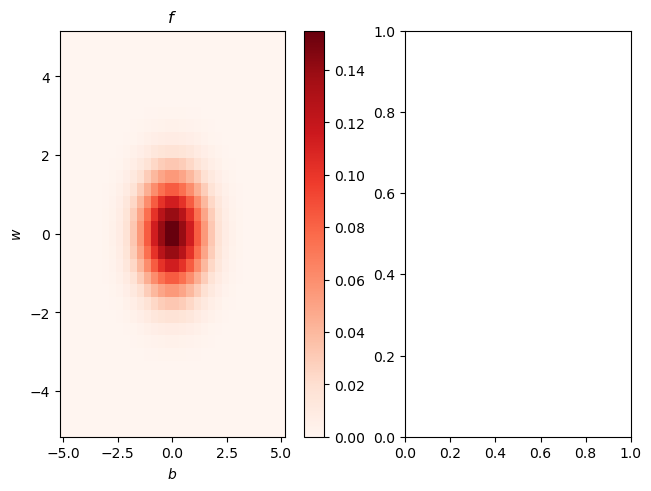

t = 0.100 



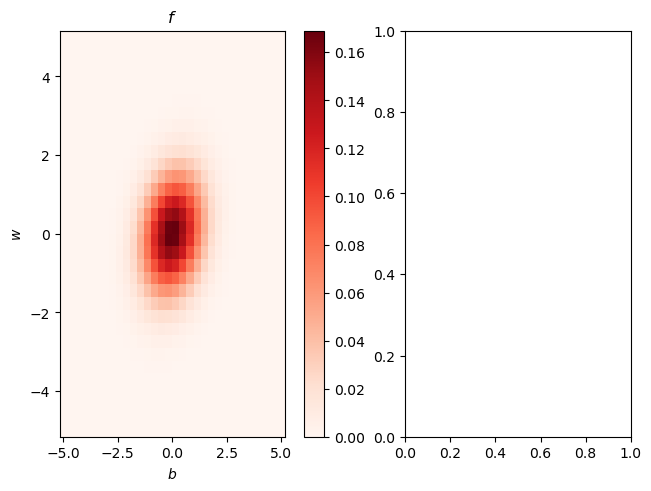

t = 0.200 



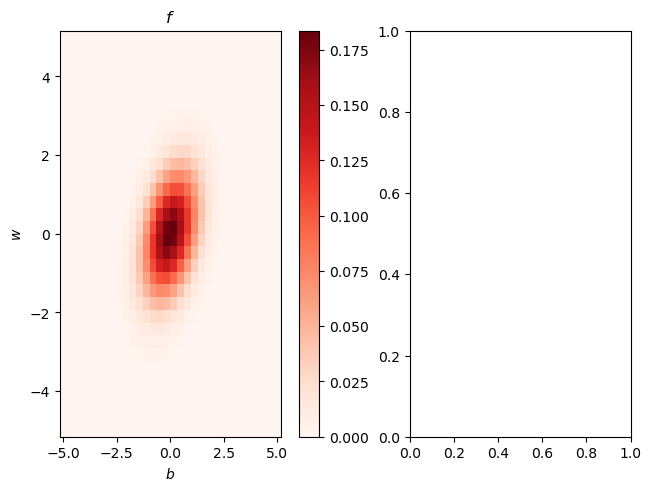

t = 0.300 



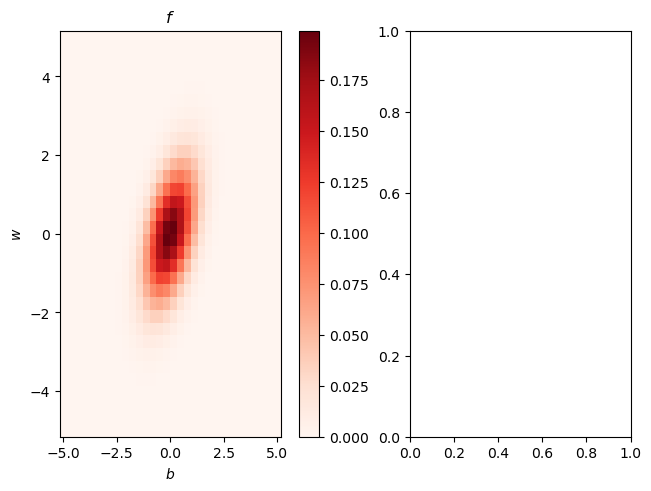

t = 0.400 



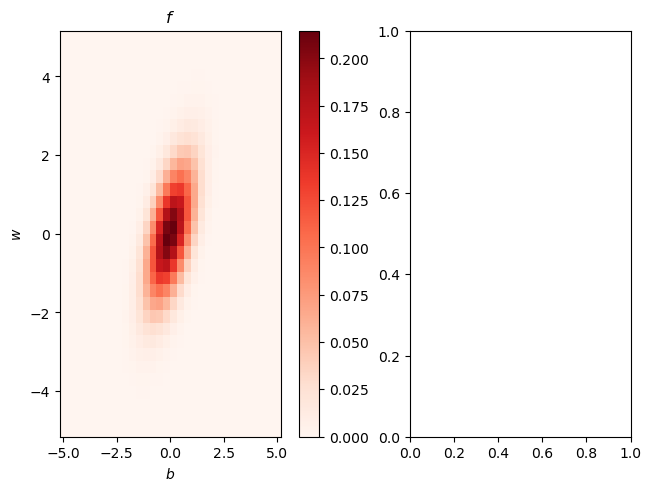

t = 0.501 



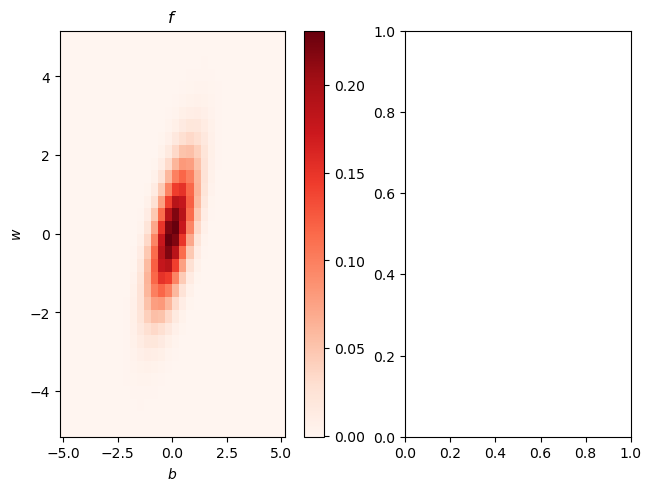

t = 0.601 



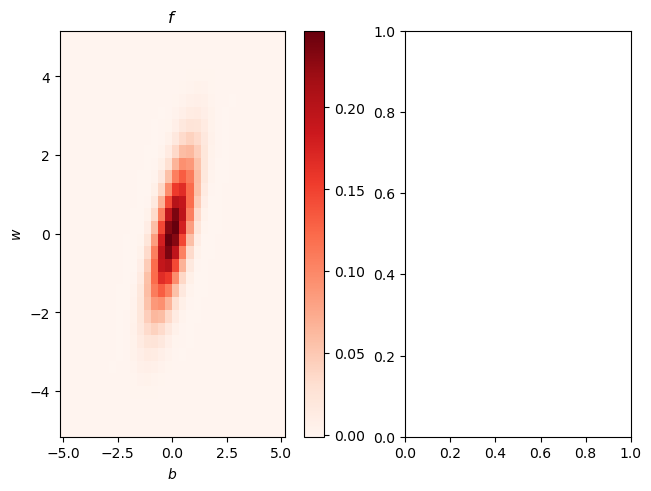

t = 0.701 



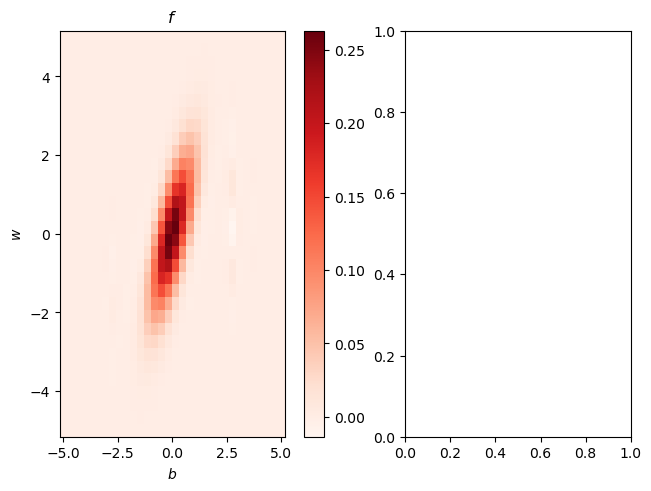

t = 0.801 



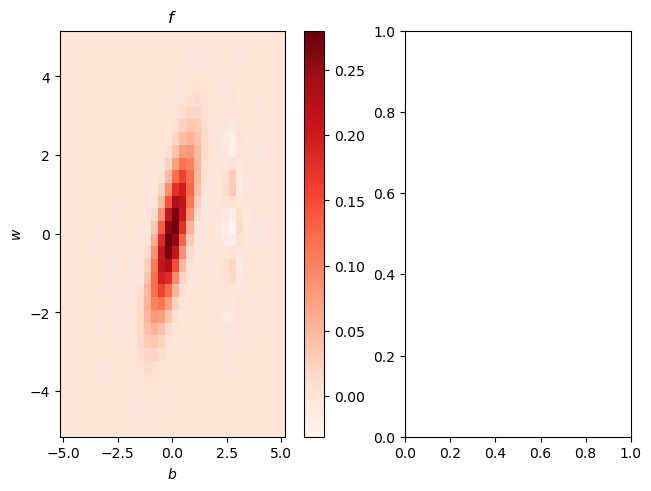

t = 0.901 



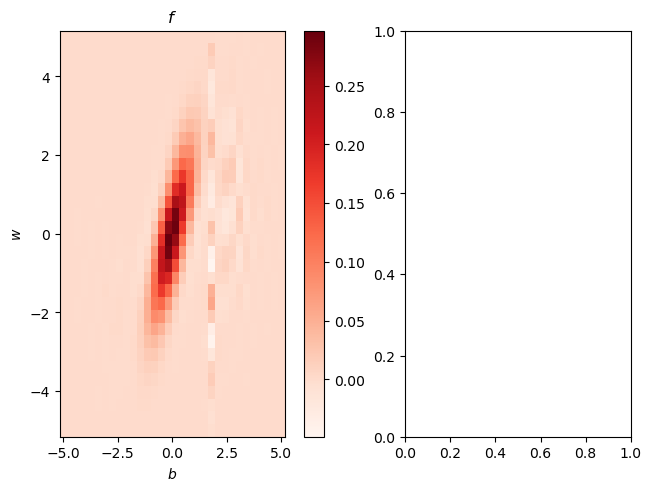

In [52]:
N_T = 10**3
T, Δt = np.linspace(0,1,N_T,retstep=True)
print('Δt = ',Δt)

# Initial conditions for f shape b, w
def g(z):
    return np.exp(-z**2/2)/np.sqrt(2*np.pi)

f = np.outer( g(b), g(w) )

# Flatten the inputs and pass them to the solver and check with reshape
f = f.flatten()

solver(f, b, w, T, Δt)